# This is an exmaple of how EfficientNet is build by Tensorflow 2

EfficientNet的思想是同时按比例控制输入图片大小, 卷积个数, 神经网络深度来提高模型的表现
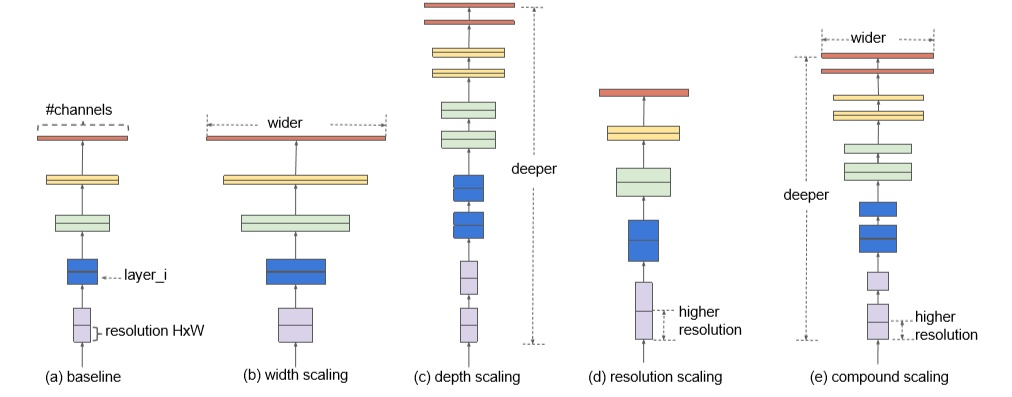

In this paper, we propose a new compound scaling method, which use a compound coefficient φ to uniformly scales network width, depth, and resolution in a principled way:

    depth: d = α**φ
    width: w = β**φ
    resolution: r = γ**φ
        s.t. α·β**2·γ**2 ≈ 2
        α ≥ 1, β ≥ 1, γ ≥ 1

EfficientNet B0 的网络结构如下
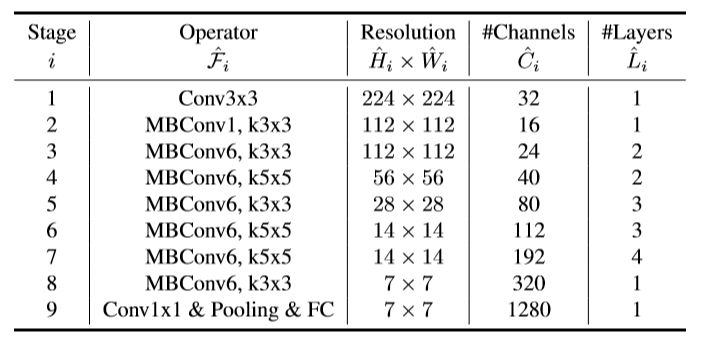

通道域（Channel Domain）—— SE Block

这种注意力主要分布在channel中，表现在图像上就是对不同的图像通道的关注程度不同。反映在数学上就是指：针对某个大小为H×W×C的特征图，有效的一个通道注意力对应一个大小为1×1×C的矩阵，每个位置对原特征图对应channel的全部像素是一个权重，计算时做channel-wise multiply。

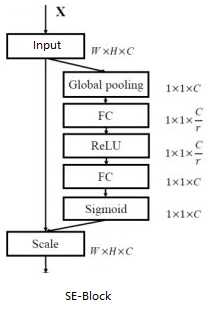

EfficientNet模型的内部是通过多个MBConv卷积块实现的，每个MBConv卷积块的具体结构如下：
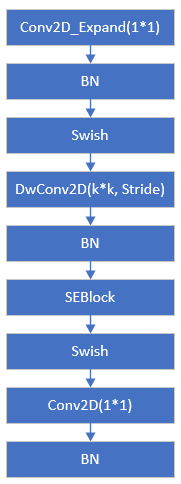

其中SeparableConv2D实现整个深度分离卷积过程，即深度方向的空间卷积 (分别作用于每个输入通道)+ 输出通道混合在一起的逐点卷积，
而DepthwiseConv2D仅仅实现前半部分的空间卷积 (分别作用于每个输入通道)

In [2]:
import tensorflow as tf
from tensorflow.keras import *
import math

print(tf.__version__)
print(tf.keras.__version__)

2.1.0
2.2.4-tf


In [30]:
class Swish(layers.Layer):
    def __init__(self, **kwargs):
        self.layer_sigmoid = layers.Activation('sigmoid')
        super().__init__(**kwargs)
    
    def call(self, inputs):
        return inputs * self.layer_sigmoid(inputs)
        
class SEBlock(layers.Layer):
    def __init__(self, input_channels, ratio=0.25, **kwargs):
        self.num_reduced_filters = max(1, int(input_channels * ratio))
        self.layer_gap = layers.GlobalAveragePooling2D()
        self.layer_conv_reduce = layers.Conv2D(filters=self.num_reduced_filters, kernel_size=(1, 1), strides=1, padding="same")
        self.layer_conv_expand = layers.Conv2D(filters=input_channels, kernel_size=(1, 1), strides=1, padding="same")
        self.layer_sigmoid = layers.Activation('sigmoid')
        self.layer_swish = Swish()
        super().__init__(**kwargs)
        
    def call(self, inputs):
        #Global Average Pooling
        branch = self.layer_gap(inputs)
        branch = tf.expand_dims(input=branch, axis=1)
        branch = tf.expand_dims(input=branch, axis=1)
        # Conv1 with dimension Reduction
        branch = self.layer_conv_reduce(branch)
        branch = self.layer_swish(branch)
        # Conn2 With dimension expandion
        branch = self.layer_conv_expand(branch)
        branch = self.layer_sigmoid(branch)
        # multiply back
        output = inputs * branch
        return output

class MBConv(layers.Layer):
    def __init__(self, in_channels, out_channels, expansion_factor, stride, k, drop_connect_rate, **kwargs):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.drop_connect_rate = drop_connect_rate
        self.layer_conv1 = layers.Conv2D(filters=in_channels * expansion_factor, kernel_size=(1, 1), strides=1, padding="same")
        self.layer_bn1 = layers.BatchNormalization()
        self.layer_dwconv = layers.DepthwiseConv2D(kernel_size=(k, k), strides=stride, padding="same")
        self.layer_bn2 = layers.BatchNormalization()
        self.layer_se = SEBlock(input_channels=in_channels * expansion_factor)
        self.layer_swish = Swish()
        self.layer_conv2 = layers.Conv2D(filters=out_channels, kernel_size=(1, 1), strides=1, padding="same")
        self.layer_bn3 = layers.BatchNormalization()
        self.layer_dropout = layers.Dropout(rate=drop_connect_rate)
        super().__init__(**kwargs)

    def call(self, inputs, training=None, **kwargs):
        #Expand channels based on in_channels
        x = self.layer_conv1(inputs)
        x = self.layer_bn1(x, training=training)
        x = self.layer_swish(x)
        #Depthwise with Se-Block
        x = self.layer_dwconv(x)
        x = self.layer_bn2(x, training=training)
        x = self.layer_se(x)
        x = self.layer_swish(x)
        #Reduce channels based on out_channels
        x = self.layer_conv2(x)
        x = self.layer_bn3(x, training=training)
        # Add dropout
        if self.stride == 1 and self.in_channels == self.out_channels:
            if self.drop_connect_rate:
                x = self.layer_dropout(x, training=training)
            x = add([x, inputs])
        return x

class MBConvBlocks(layers.Layer):
    def __init__(self, in_channels, out_channels, layers, stride, expansion_factor, k, drop_connect_rate, **kwargs):
        self.layer_blocks = []
        for i in range(layers):
            if i == 0:
                self.layer_blocks.append(MBConv(in_channels, out_channels, expansion_factor, stride, k, drop_connect_rate))
            else:
                self.layer_blocks.append(MBConv(in_channels, out_channels, expansion_factor, 1, k, drop_connect_rate))
        super().__init__(**kwargs)        
                
    def call(self, inputs, training=None, **kwargs):
        x = inputs
        for layer in self.layer_blocks:
            x = layer(x)
        return x

    
def CustomizedEfficientNet(input_shape, width_coefficient, depth_coefficient, dropout_rate, drop_connect_rate=0.2, num_classes=10, name = '', **kwargs):
    def round_filters(filters, multiplier):
        depth_divisor = 8
        min_depth = depth_divisor
        filters = filters * multiplier
        new_filters = max(min_depth, int(filters + depth_divisor / 2) // depth_divisor * depth_divisor)
        if new_filters < 0.9 * filters:
            new_filters += depth_divisor
        return int(new_filters)

    def round_repeats(repeats, multiplier = 1):
        return int(math.ceil(multiplier * repeats))
    
    
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(filters=round_filters(32, width_coefficient), kernel_size=(3, 3), strides=2, padding="same", name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn1')(x)
    x = Swish(name='swish1')(x)

    x = MBConvBlocks(in_channels=round_filters(32, width_coefficient),
                         out_channels=round_filters(16, width_coefficient),
                         layers=round_repeats(1, depth_coefficient),
                         stride=1,
                         expansion_factor=1, k=3, drop_connect_rate=drop_connect_rate, name='MBConvBlocks1')(x)
    x = MBConvBlocks(in_channels=round_filters(16, width_coefficient),
                         out_channels=round_filters(24, width_coefficient),
                         layers=round_repeats(2, depth_coefficient),
                         stride=2,
                         expansion_factor=6, k=3, drop_connect_rate=drop_connect_rate, name='MBConvBlocks2')(x)
    x = MBConvBlocks(in_channels=round_filters(24, width_coefficient),
                         out_channels=round_filters(40, width_coefficient),
                         layers=round_repeats(2, depth_coefficient),
                         stride=2,
                         expansion_factor=6, k=5, drop_connect_rate=drop_connect_rate, name='MBConvBlocks3')(x)
    x = MBConvBlocks(in_channels=round_filters(40, width_coefficient),
                         out_channels=round_filters(80, width_coefficient),
                         layers=round_repeats(3, depth_coefficient),
                         stride=2,
                         expansion_factor=6, k=3, drop_connect_rate=drop_connect_rate, name='MBConvBlocks4')(x)
    x = MBConvBlocks(in_channels=round_filters(80, width_coefficient),
                         out_channels=round_filters(112, width_coefficient),
                         layers=round_repeats(3, depth_coefficient),
                         stride=1,
                         expansion_factor=6, k=5, drop_connect_rate=drop_connect_rate, name='MBConvBlocks5')(x)
    x = MBConvBlocks(in_channels=round_filters(112, width_coefficient),
                         out_channels=round_filters(192, width_coefficient),
                         layers=round_repeats(4, depth_coefficient),
                         stride=2,
                         expansion_factor=6, k=5, drop_connect_rate=drop_connect_rate, name='MBConvBlocks6')(x)
    x = MBConvBlocks(in_channels=round_filters(192, width_coefficient),
                         out_channels=round_filters(320, width_coefficient),
                         layers=round_repeats(1, depth_coefficient),
                         stride=1,
                         expansion_factor=6, k=3, drop_connect_rate=drop_connect_rate, name='MBConvBlocks7')(x)

    x = layers.Conv2D(filters=round_filters(1280, width_coefficient), kernel_size=(1, 1), strides=1, padding="same", name='conv2')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = Swish(name='swish2')(x)
    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dropout(rate=dropout_rate, name='dropout')(x)
    x = layers.Dense(units=num_classes, activation=activations.softmax, name='fc')(x)
    
    return Model(inputs, x, name=name)

def EfficientNet(b, num_classes):
    net_parm = {'b0':([224, 224, 3], 1.0, 1.0, 0.2),
                'b1':([240, 240, 3], 1.0, 1.1, 0.2),
                'b2':([260, 260, 3], 1.1, 1.2, 0.3),
                'b3':([300, 300, 3], 1.2, 1.4, 0.3),
                'b4':([380, 380, 3], 1.4, 1.8, 0.4),
                'b5':([456, 456, 3], 1.6, 2.2, 0.4),
                'b6':([528, 528, 3], 1.8, 2.6, 0.5),
                'b7':([600, 600, 3], 2.0, 3,1, 0.5)}[b]
    return CustomizedEfficientNet(net_parm[0], net_parm[1], net_parm[2], net_parm[3], num_classes=num_classes)

In [31]:
EfficientNet('b0', 10).summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      896       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 112, 112, 32)      128       
_________________________________________________________________
swish1 (Swish)               (None, 112, 112, 32)      0         
_________________________________________________________________
MBConvBlocks1 (MBConvBlocks) (None, 112, 112, 16)      2776      
_________________________________________________________________
MBConvBlocks2 (MBConvBlocks) (None, 56, 56, 24)        21792     
_________________________________________________________________
MBConvBlocks3 (MBConvBlocks) (None, 28, 28, 40)        5231

Total params: 4,682,358
Trainable params: 4,650,070
Non-trainable params: 32,288